In [2]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import scipy

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

#from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator 

In [41]:
!nvidia-smi

Fri May 28 16:54:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:82:00.0 Off |                    0 |
| N/A   31C    P0    34W / 250W |  15749MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
path = './all/'
count = 0
for root,dirs,files in os.walk(path):
      for each in files:
          if each.endswith('png'):
             count += 1
print ("圖片數量：",count)

圖片數量： 54415


# 1. Data Exploration

In [3]:
df = pd.read_excel("liddar_img_v2.xlsx")
print(df.shape)
print(df.head(3))

(2262, 3)
                image    False_Reason Label
0  9622-1-029_001.png  Electric Tower     Y
1  9622-1-029_002.png  Electric Tower     Y
2  9622-1-030_001.png  Electric Tower     Y


In [14]:
toy=False
if toy:
    all = all.sample(2000)
print(df.shape)
print(df.head(3))

(2262, 3)
                image    False_Reason Label
0  9622-1-029_001.png  Electric Tower     Y
1  9622-1-029_002.png  Electric Tower     Y
2  9622-1-030_001.png  Electric Tower     Y


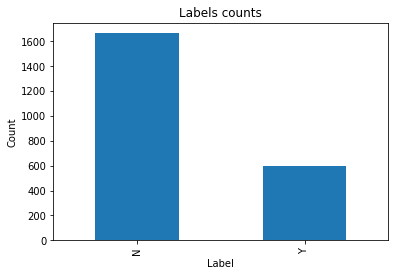

In [15]:
df.Label.value_counts().plot(kind='bar')
plt.style.use('fast')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [18]:
class ImageViewer:
    def read_img(self,id):
        """
        Read image by it's id
        """
        file='./all/'+ str(id)
        im=cv2.imread(file)
        return im

    def draw_sample_images(self):
        """
        Draw cancer and healthy images for EDA
        """
        ncols=4
        plt.style.use('default')
        f, ax = plt.subplots(nrows=2,ncols=ncols, 
                             figsize=(4*ncols,5*2))
        i=-1
        captions=['N', 'Y']
        # Draw one row for cancer, one row for healthy images
        for label in ['N','Y']:
            i=i+1
            samples = df[df['Label']==label]['image'].sample(ncols).values
            for j in range(0,ncols):
                file_id=samples[j]
                im=self.read_img(file_id)
                ax[i, j].imshow(im)
                ax[i, j].set_title(captions[i], fontsize=16)  
        plt.tight_layout()
        plt.show()

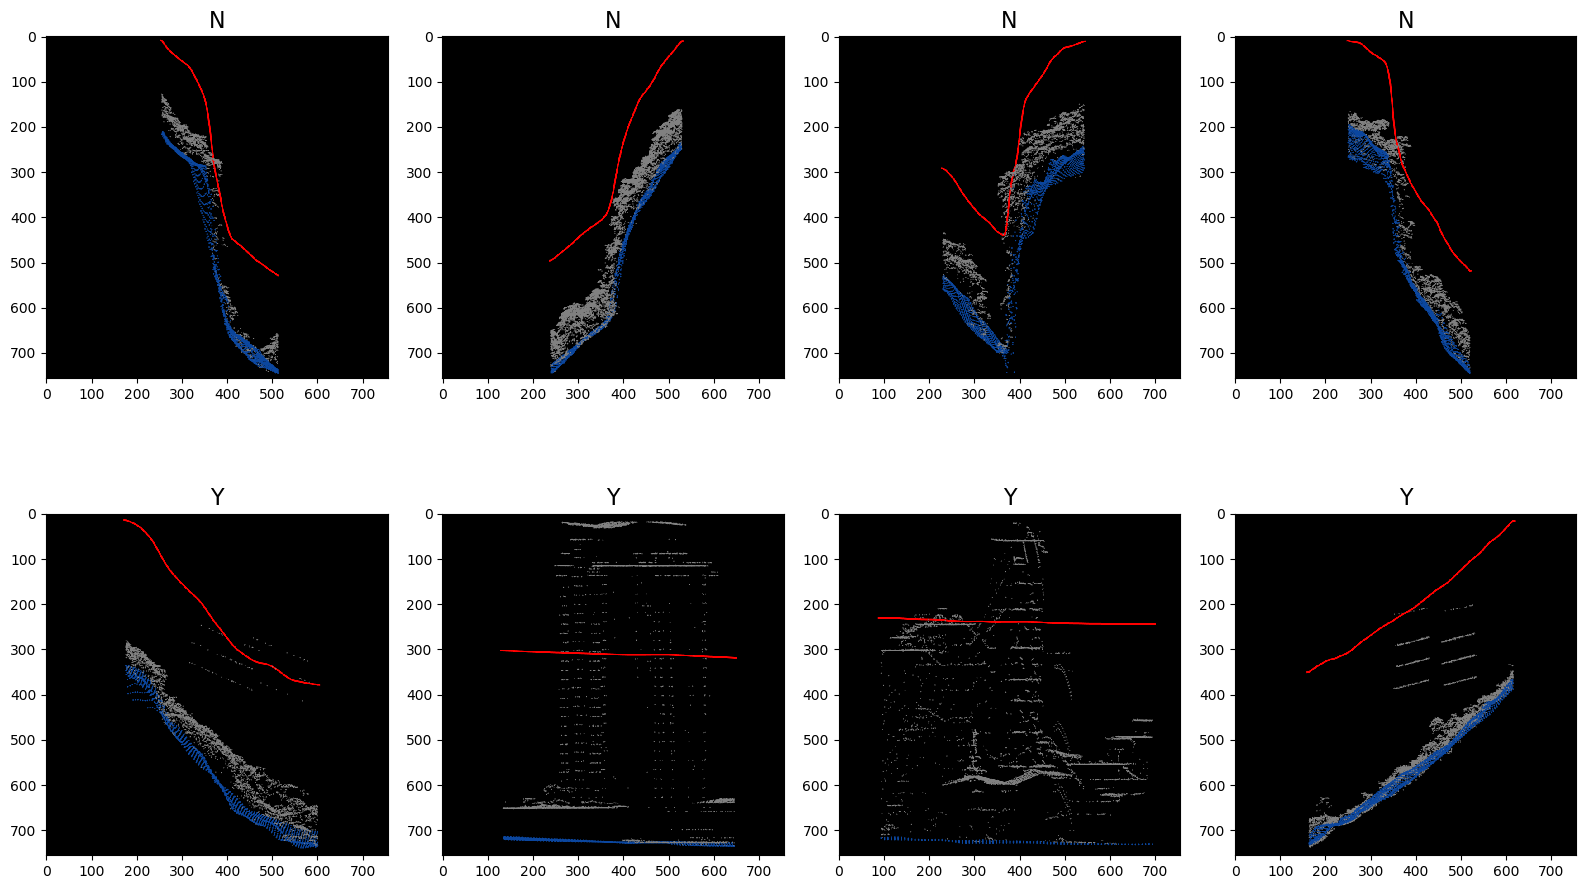

In [19]:
ImageViewer().draw_sample_images()

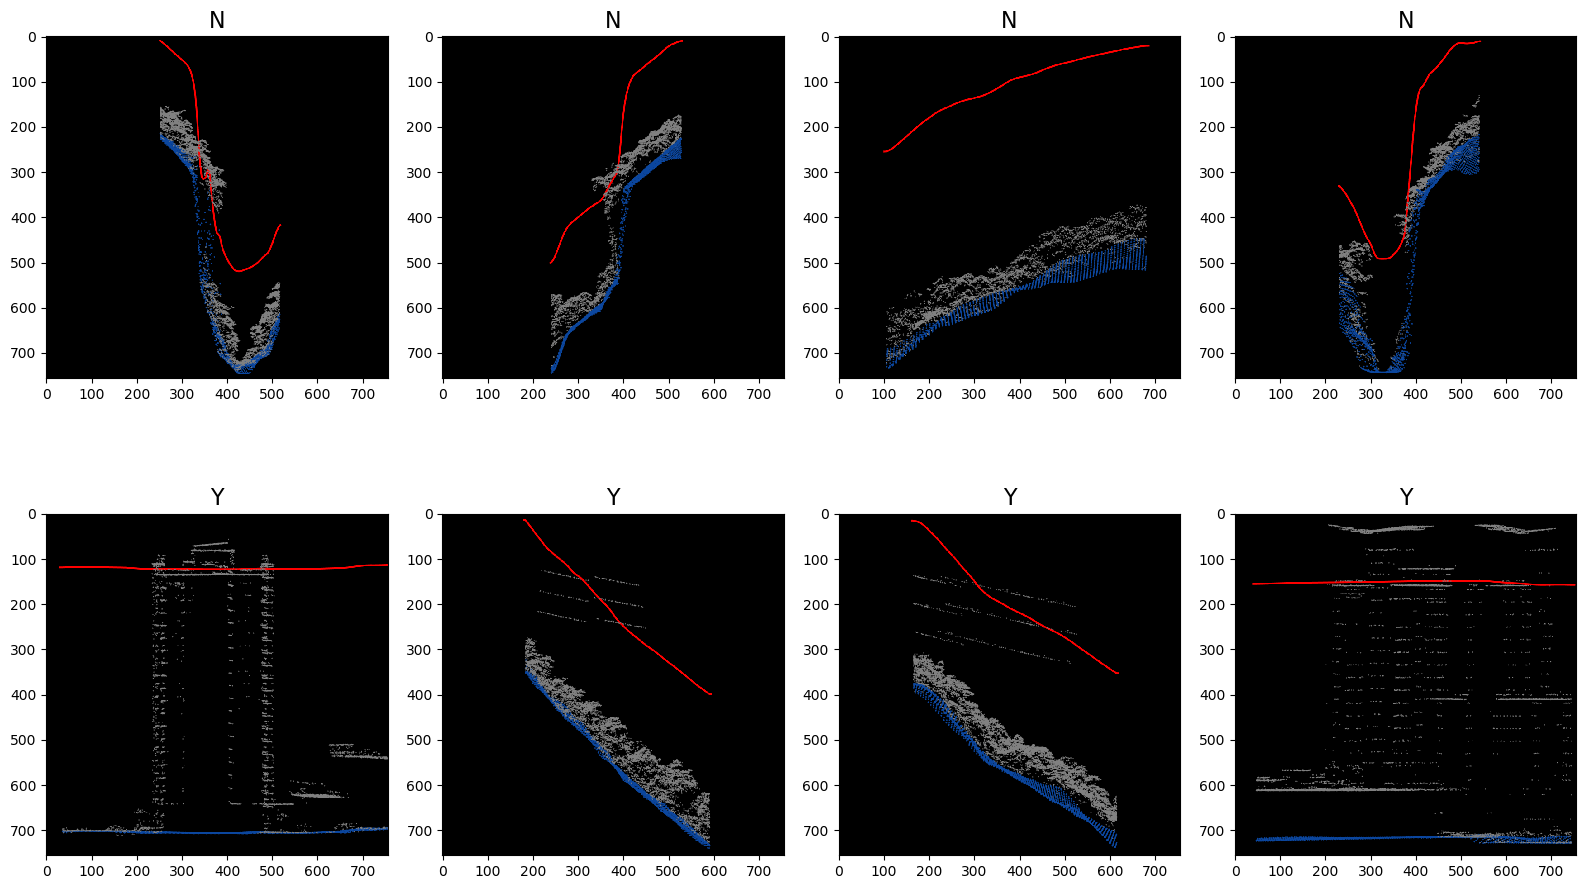

In [20]:
ImageViewer().draw_sample_images()

# 2. Data Preprocess
Here we are going to balance dataset and prepare image generator

In [21]:
class DataPreparation:
    """
    Train/test
    """
    def train_test_split(self, all_df):
        """
        Balanced split to train, test and val
        """
        # Split to train and test before balancing
        train_df, test_df = train_test_split(df, random_state=24)
#         # Split train to train and validation datasets
#         train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=24)
        # Number of samples in each category
        ncat_bal = df['Label'].value_counts().max()
        #ncat_bal = int(len(train_df)/train_df['label'].cat.categories.size)
        train_df = train_df.groupby('Label', as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True, random_state=24)).reset_index(drop=True)
        return train_df, test_df
    
    def plot_balanced(self, train_df, df):
        """
        Plot samples per category before and after balancing
        """
        f, axs = plt.subplots(1,2,figsize=(12,4))
        # Before balancing
        df.Label.value_counts().plot(kind='bar', ax=axs[0])
        axs[0].set_title('All labels')
        axs[0].set_xlabel('Label')
        axs[0].set_ylabel('Count')
        # After balancing
        train_df.Label.value_counts().plot(kind='bar', ax=axs[1])
        axs[1].set_title('Train labels after balancing')
        axs[1].set_xlabel('Label')
        axs[1].set_ylabel('Count')
        plt.tight_layout()
        plt.show()

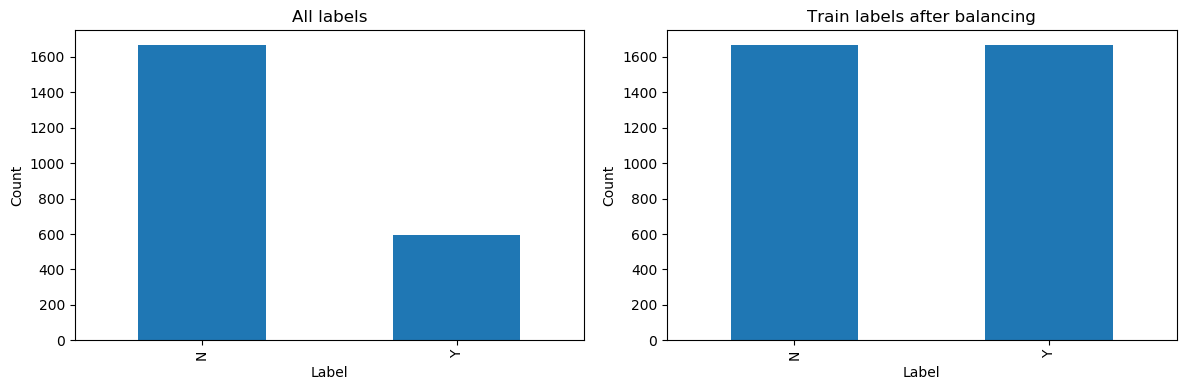

In [22]:
# Train/test/validation split with balanced labels in train
data_prep = DataPreparation()
train_df, test_df = data_prep.train_test_split(df)

# Plot before and after balancing
data_prep.plot_balanced(train_df, df)

In [23]:
class Generators:
    """
    Train, validation and test generators
    """
    def __init__(self, train_df, test_df):
        self.batch_size=32
        self.img_size=(64,64)
        
        # Base train/validation generator
        _datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.25,
            featurewise_center=False,
            featurewise_std_normalization=False,
            rotation_range=90,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
            )
        # Train generator
        self.train_generator = _datagen.flow_from_dataframe(
            dataframe=train_df,
            directory="./all/",
            x_col="image",
            y_col="Label",
            has_ext=False,
            subset="training",
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=self.img_size)
        print('Train generator created')
        # Validation generator
        self.val_generator = _datagen.flow_from_dataframe(
            dataframe=train_df,
            directory="./all/",
            x_col="image",
            y_col="Label",
            has_ext=False,
            subset="validation",
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=self.img_size)    
        print('Validation generator created')
        # Test generator
        _test_datagen=ImageDataGenerator(rescale=1./255.)
        self.test_generator = _test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory="./all/",
            x_col="image",
            y_col='Label',
            has_ext=False,
            class_mode="categorical",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False,
            target_size=self.img_size)     
        print('Test generator created')

In [24]:
# Create generators        
generators = Generators(train_df, test_df)
print("Generators created")

Found 2499 validated image filenames belonging to 2 classes.
Train generator created
Found 833 validated image filenames belonging to 2 classes.
Validation generator created
Found 566 validated image filenames belonging to 2 classes.
Test generator created
Generators created


# 3. Model Training

In [25]:
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [26]:
class ModelTrainer:
    """
    Create and fit the model
    """
    
    def __init__(self, generators):
        self.generators = generators
        self.img_width = generators.img_size[0]
        self.img_height = generators.img_size[1]
        
    def create_model_small(self):
        """
        Build CNN model using img_width, img_height from fields.
        """
        model=Sequential()
        model.add(Conv2D(16, kernel_size=3, input_shape=(self.img_width, self.img_height,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(2))
        model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
        model.add(Dropout(0.1))
        model.add(Flatten())
        model.add(Dense(64, activation = "relu"))        
        # 1 y label
        model.add(Dense(2, activation='softmax'))
        model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def create_model(self,
                    kernel_size = (3,3),
                    pool_size= (2,2),
                    first_filters = 32,
                    second_filters = 64,
                    third_filters = 128,
                    first_dense=256,
                    second_dense=128,
                    dropout_conv = 0.3,
                    dropout_dense = 0.3):

        model = Sequential()
        # First conv filters
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding="same",
                         input_shape = (self.img_width, self.img_height,3)))
        model.add(Conv2D(first_filters, kernel_size, padding="same", activation = 'relu'))
        model.add(Conv2D(first_filters, kernel_size, padding="same", activation = 'relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 
        model.add(Dropout(dropout_conv))

        # Second conv filter
        model.add(Conv2D(second_filters, kernel_size, padding="same", activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, padding="same", activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, padding="same", activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Dropout(dropout_conv))

        # Third conv filter
        model.add(Conv2D(third_filters, kernel_size, padding="same", activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, padding="same", activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, padding="same", activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Dropout(dropout_conv))

        model.add(Flatten())
        
        # First dense
        model.add(Dense(first_dense, activation = "relu"))
        model.add(Dropout(dropout_dense))
        # Second dense
        model.add(Dense(second_dense, activation = "relu"))
        model.add(Dropout(dropout_dense))
        
        # Out layer
        model.add(Dense(2, activation = "softmax"))

        model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
        return model
        
    
    def train(self, model, toy):
        """
        Train the model
        """
        if toy:
            epochs=3
            steps_per_epoch=20
            validation_steps=2
        else:
            epochs=50
            steps_per_epoch=50
            #steps_per_epoch=30
            #steps_per_epoch=10
            validation_steps=5
            
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
        # Save the best model during the traning
        checkpointer = ModelCheckpoint('best_model1.h5'
                                        ,monitor='val_acc'
                                        ,verbose=1
                                        ,save_best_only=True
                                        ,save_weights_only=True)
        # Train
        training = model.fit_generator(generator=self.generators.train_generator
                                ,epochs=epochs
                                ,steps_per_epoch=steps_per_epoch
                                ,validation_data=self.generators.val_generator
                                ,validation_steps=validation_steps
                                ,callbacks=[earlystopper, checkpointer, reduce_lr])
        # Get the best saved weights
        #model.load_weights('best_model1.h5')
        return training

In [27]:
# Create and train the model
trainer = ModelTrainer(generators)

In [28]:
model = trainer.create_model(kernel_size = (3,3),
                    pool_size= (2,2),
                    first_filters = 128,
                    second_filters = 256,
                    third_filters = 512,
                    first_dense=256,
                    second_dense=128,
                    dropout_conv = 0.3,
                    dropout_dense = 0.2)

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 256)     

In [29]:
training=trainer.train(model,toy)
print("Trained")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
50/50 [==============================] - 74s 1s/step - loss: 0.5729 - accuracy: 0.6957 - val_loss: 0.8348 - val_accuracy: 0.2812
Epoch 2/50


/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50/50 [==============================] - 43s 866ms/step - loss: 0.4815 - accuracy: 0.7700 - val_loss: 0.7226 - val_accuracy: 0.6000
Epoch 3/50


/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50/50 [==============================] - 40s 800ms/step - loss: 0.4432 - accuracy: 0.8059 - val_loss: 0.7127 - val_accuracy: 0.6562
Epoch 4/50
50/50 [==============================] - 33s 657ms/step - loss: 0.3800 - accuracy: 0.8453 - val_loss: 0.5135 - val_accuracy: 0.8375
Epoch 5/50
50/50 [==============================] - 29s 586ms/step - loss: 0.3163 - accuracy: 0.8775 - val_loss: 0.3839 - val_accuracy: 0.8938
Epoch 6/50
50/50 [==============================] - 36s 712ms/step - loss: 0.2984 - accuracy: 0.8784 - val_loss: 0.3890 - val_accuracy: 0.8605
Epoch 7/50
50/50 [==============================] - 31s 619ms/step - loss: 0.2979 - accuracy: 0.8788 - val_loss: 0.5301 - val_accuracy: 0.8250
Epoch 8/50
50/50 [==============================] - 31s 613ms/step - loss: 0.2493 - accuracy: 0.9141 - val_loss: 0.3317 - val_accuracy: 0.7688
Epoch 9/50
50/50 [==============================] - 30s 594ms/step - loss: 0.2468 - accuracy: 0.9058 - val_loss: 0.4609 - val_accuracy: 0.7937
Epoch 10/5

In [30]:
#model.load_weights('best_model1.h5')
model.save('model_0528.h5')

In [ ]:
from keras.models import load_model
model = load_model('model_0528.h5')

Using TensorFlow backend.


# 4. Test

In [31]:
class Evaluator:
    """
    Evaluaion :predict on test data (not submission data from test folder)
    and print reports, plot results etc.
    """
     
    def __init__(self, model, training, generator, y_true):
        self.training = training
        self.generator = generator
        # predict the data
        steps=5
        self.y_pred_raw = model.predict_generator(self.generator, steps=steps)
        self.y_pred = np.argmax(self.y_pred_raw, axis=1)
        self.y_true=y_true[:len(self.y_pred)]
        self.y_true = np.where(self.y_true=='N', 0, self.y_true)
        self.y_true = np.where(self.y_true=='Y', 1, self.y_true)        
    
    """
    Accuracy, evaluation
    """
    def plot_history(self):
        """
        Plot training history
        """
        ## Trained model analysis and evaluation
        f, ax = plt.subplots(1,2, figsize=(12,3))
        ax[0].plot(self.training.history['loss'], label="Loss")
        ax[0].plot(self.training.history['val_loss'], label="Validation loss")
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Accuracy
        ax[1].plot(self.training.history['accuracy'], label="Accuracy")
        ax[1].plot(self.training.history['val_accuracy'], label="Validation accuracy")
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.tight_layout()
        plt.show()
    
    def plot_roc(self):
        #y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
        # Calculate roc
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(self.y_true, self.y_pred)
        auc_keras = auc(fpr_keras, tpr_keras)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        
    def print_report(self):
        """
        Predict and evaluate using ground truth from labels
        Test generator did not shuffle 
        and we can use true labels for comparison
        """
        #Print classification report
        print(metrics.classification_report(self.y_true, self.y_pred))

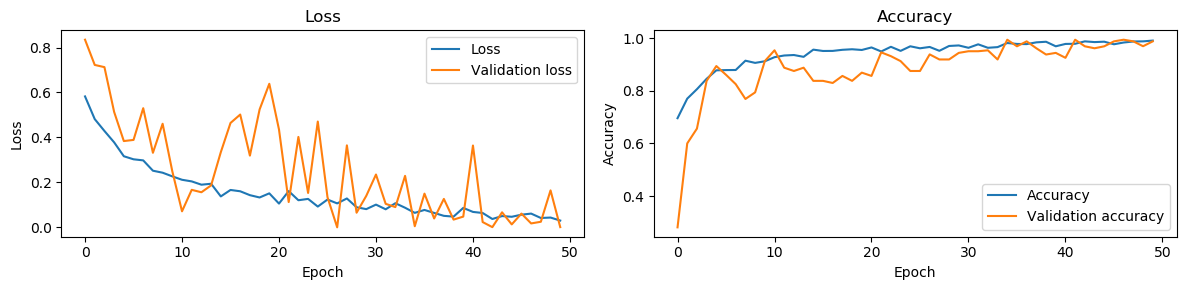

In [32]:
# Create evaluator instance
evaluator = Evaluator(model, training, generators.test_generator, test_df.Label.values)

# Draw accuracy and loss charts
evaluator.plot_history()

In [33]:
steps=5
#generators.test_generator
y_pred_raw = model.predict_generator(generators.test_generator, steps=steps)
y_pred = np.argmax(y_pred_raw, axis=1)

In [34]:
y_pred

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1])

In [35]:
y_true=test_df.Label.values
y_true

array(['N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'N',
       'N', 'Y', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N',
       'N', 'Y', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'N',
       'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'N',
       'N', 'N', 'N', 'Y', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'Y',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'Y', 'N', 'Y', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'Y', 'Y',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'Y', 'Y',
       'N', 'N', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'N',
       'N', 'Y', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'Y', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'Y', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'Y', 'Y',
       'N', 'Y', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'N', 'N', 'N', 'N

In [36]:
y_true=y_true[:len(y_pred)]

In [37]:
y_true = np.where(y_true=='N', 0, y_true)
y_true = np.where(y_true=='Y', 1, y_true)

In [38]:
def performance_model(prediction,y_test):
    # Get Label in array
    list = []
    for i in y_test:
        list.append(i)
    arr = np.arange(len(y_test)).reshape(len(y_test),1)
    np.place(arr, arr>=0, list)
    # TN: True Nagetive, TP: True Positive, FP: False Positive, FN: False Nagetive
    i = 0
    TN = 0
    TP = 0
    FP = 0
    FN = 0
    while i < len(y_test):
        if prediction[i] == arr[i]:
            if prediction[i] == 0:
                TN += 1
            else:
                TP += 1
        else:
            if prediction[i] == 1:
                FP += 1
            else:
                FN += 1
        i += 1
    #  Accuracy (ACC), precision (PR), recall (RC),and F-score(FS)
    ACC = (TN+TP)/(TN+TP+FP+FN)
    PR = TP/(TP+FP)
    RC = TP/(TP+FN)
    FS = 2*(PR*RC)/(PR+RC)
    return(ACC,PR,RC,FS)

In [39]:
ACC,PR,RC,FS = performance_model(y_pred,y_true)
print('Accuracy: ',ACC)
print('Precision:',PR)
print('Recall: ',RC)
print('F-score: ',FS)

Accuracy:  0.96875
Precision: 0.9333333333333333
Recall:  0.9545454545454546
F-score:  0.9438202247191012
